# Verbesserte Automerkennung auf Bildern (PIL-Version)

Dieses Notebook implementiert eine verbesserte Automerkennung auf Bildern mit dem trainierten CNN-Modell. Es verwendet einen kombinierten Ansatz mit Selective Search für Region Proposals und Multi-Scale-Erkennung, um Autos in Bildern zuverlässiger zu lokalisieren und zu markieren. Diese Version verwendet PIL anstelle von OpenCV für die Bildverarbeitung, um Kompatibilität mit Python 3.11 zu gewährleisten.

## Überblick
- Laden des trainierten CNN-Modells
- Implementierung eines alternativen Algorithmus für Region Proposals
- Verbesserte Multi-Scale-Erkennung für verschiedene Objektgrößen
- Optimierte Non-Maximum Suppression zur Entfernung überlappender Bounding Boxes
- Anwendung auf Testbilder und Visualisierung der Ergebnisse

## Importieren der benötigten Bibliotheken

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import os
import requests
from io import BytesIO
from PIL import Image, ImageDraw, ImageFont
import time
from skimage.feature import hog
from skimage import exposure

## Vorbereitung der Verzeichnisse

Wir erstellen die notwendigen Verzeichnisse für Bilder und Ergebnisse.

In [15]:
# Verzeichnisse
models_dir = '../models'
data_dir = '../data'
images_dir = '../images'
results_dir = '../results'

os.makedirs(images_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

## Laden des trainierten Modells

Wir laden das in den vorherigen Notebooks trainierte CNN-Modell zur Autoerkennung.

In [16]:
# Laden des trainierten Modells
print("Laden des trainierten Modells...")
try:
    model = load_model(os.path.join(models_dir, 'keras_cnn', 'car_detection_model.keras'))
    print("Modell erfolgreich geladen.")
except:
    print("Fehler beim Laden des Modells. Bitte stellen Sie sicher, dass das Modell trainiert wurde.")
    # In einem Notebook verwenden wir keinen exit(1), sondern werfen eine Exception
    raise Exception("Modell konnte nicht geladen werden.")

Laden des trainierten Modells...
Modell erfolgreich geladen.


## Funktionen für die Bildverarbeitung und Objekterkennung

### Laden und Vorverarbeiten von Bildern

In [17]:
def load_and_preprocess_image(image_path, target_size=(32, 32)):
    """
    Lädt ein Bild und bereitet es für die Vorhersage vor.
    
    Args:
        image_path: Pfad zum Bild oder URL
        target_size: Zielgröße für das Modell
        
    Returns:
        image: Originalbild
        processed_image: Vorverarbeitetes Bild für das Modell
        (original_height, original_width): Originalgröße des Bildes
    """
    # Überprüfen, ob es sich um eine URL handelt
    if image_path.startswith('http'):
        response = requests.get(image_path)
        pil_image = Image.open(BytesIO(response.content))
    else:
        pil_image = Image.open(image_path)
    
    # Convert PIL image to numpy array
    image = np.array(pil_image)
    
    # Speichern der Originalgröße
    original_height, original_width = image.shape[:2]
    
    # Vorverarbeitung für das Modell
    pil_resized = pil_image.resize(target_size)
    processed_image = np.array(pil_resized).astype('float32') / 255.0
    
    return image, processed_image, (original_height, original_width)

### Alternative zu Selective Search für Region Proposals

Da wir OpenCV nicht verwenden, implementieren wir eine alternative Methode für Region Proposals.

In [18]:
def selective_search_regions_alternative(image, method='fast'):
    """
    Implementiert eine alternative zu Selective Search für Region Proposals.
    
    Args:
        image: Eingabebild
        method: 'fast' oder 'quality' für die Anzahl der generierten Regionen
        
    Returns:
        regions: Liste der vorgeschlagenen Regionen (x, y, w, h)
    """
    height, width = image.shape[:2]
    regions = []
    
    # Verschiedene Fenstergrößen und Schrittweiten basierend auf der Methode
    if method == 'fast':
        window_sizes = [(64, 64), (96, 96), (128, 128), (196, 196), (256, 256)]
        strides = [32, 48, 64, 98, 128]
    else:  # 'quality'
        window_sizes = [(64, 64), (96, 96), (128, 128), (160, 160), (196, 196), (224, 224), (256, 256), (320, 320)]
        strides = [16, 24, 32, 48, 64, 80, 96, 128]
    
    # Generieren von Regionen mit verschiedenen Fenstergrößen und Schrittweiten
    for window_size, stride in zip(window_sizes, strides):
        for y in range(0, height - window_size[1], stride):
            for x in range(0, width - window_size[0], stride):
                regions.append((x, y, window_size[0], window_size[1]))
    
    # Zusätzliche Regionen für verschiedene Seitenverhältnisse
    aspect_ratios = [0.5, 0.75, 1.0, 1.5, 2.0]
    base_sizes = [64, 96, 128, 196, 256]
    
    for base_size in base_sizes:
        for ratio in aspect_ratios:
            w = int(base_size * ratio)
            h = int(base_size / ratio)
            stride = base_size // 2
            
            if w <= width and h <= height:
                for y in range(0, height - h, stride):
                    for x in range(0, width - w, stride):
                        regions.append((x, y, w, h))
    
    # Filtern der Regionen nach Größe
    min_area = 500  # Minimale Fläche für eine Region
    max_area = image.shape[0] * image.shape[1] * 0.8  # Maximale Fläche (80% des Bildes)
    
    filtered_regions = []
    for x, y, w, h in regions:
        area = w * h
        if min_area <= area <= max_area and w/h >= 0.5 and w/h <= 2.0:  # Verhältnis von Breite zu Höhe
            filtered_regions.append((x, y, w, h))
    
    # Entfernen von Duplikaten
    filtered_regions = list(set(filtered_regions))
    
    # Begrenzen der Anzahl der Regionen, um die Verarbeitung zu beschleunigen
    max_regions = 300 if method == 'fast' else 500
    if len(filtered_regions) > max_regions:
        # Sortieren nach Größe (absteigend) und Auswahl der größten Regionen
        filtered_regions.sort(key=lambda r: r[2] * r[3], reverse=True)
        filtered_regions = filtered_regions[:max_regions]
    
    return filtered_regions

### HOG-Feature Extraktion

Wir verwenden HOG (Histogram of Oriented Gradients) Features, um die Erkennung von Autos zu verbessern.

In [19]:
def extract_hog_features(image, target_size=(64, 64)):
    """
    Extrahiert HOG-Features aus einem Bild.
    
    Args:
        image: Eingabebild
        target_size: Zielgröße für die HOG-Feature-Extraktion
        
    Returns:
        hog_image: Visualisierung der HOG-Features
    """
    # Konvertieren in Graustufen
    if len(image.shape) == 3:
        # Verwenden von PIL für die Konvertierung in Graustufen
        pil_image = Image.fromarray(image)
        gray = np.array(pil_image.convert('L'))
    else:
        gray = image
    
    # Skalieren auf die Zielgröße
    pil_gray = Image.fromarray(gray)
    resized = np.array(pil_gray.resize(target_size))
    
    # HOG-Features extrahieren
    features, hog_image = hog(resized, orientations=9, pixels_per_cell=(8, 8),
                             cells_per_block=(2, 2), visualize=True, feature_vector=True)
    
    # Normalisieren für die Visualisierung
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    
    return hog_image_rescaled

### Verbesserte Objekterkennung mit Region Proposals

Diese Funktion kombiniert unsere alternative Region Proposal Methode mit dem CNN-Modell zur Klassifikation.

In [20]:
def detect_cars_with_region_proposals(image, model, confidence_threshold=0.9):
    """
    Erkennt Autos in einem Bild mit alternativen Region Proposals.
    
    Args:
        image: Eingabebild
        model: Trainiertes Modell
        confidence_threshold: Schwellenwert für die Konfidenz
        
    Returns:
        detections: Liste der erkannten Autos (x, y, w, h, confidence)
    """
    # Regionen mit alternativer Methode vorschlagen
    regions = selective_search_regions_alternative(image)
    
    detections = []
    
    for x, y, w, h in regions:
        # Extrahieren der Region
        if y + h <= image.shape[0] and x + w <= image.shape[1]:  # Sicherstellen, dass die Region innerhalb des Bildes liegt
            region = image[y:y+h, x:x+w]
            
            # Vorverarbeitung der Region
            try:
                pil_region = Image.fromarray(region)
                region_resized = np.array(pil_region.resize((32, 32)))
                region_normalized = region_resized.astype('float32') / 255.0
                region_batch = np.expand_dims(region_normalized, axis=0)
                
                # Vorhersage
                prediction = model.predict(region_batch, verbose=0)[0][0]
                
                # Wenn die Konfidenz über dem Schwellenwert liegt, speichern wir die Erkennung
                if prediction > confidence_threshold:
                    detections.append((x, y, w, h, prediction))
            except Exception as e:
                # Ignorieren von Regionen, die nicht verarbeitet werden können
                continue
    
    return detections

### Verbesserte Multi-Scale-Erkennung

Diese Funktion kombiniert Region Proposals mit Multi-Scale-Erkennung für eine verbesserte Automerkennung.

In [21]:
def detect_cars_multi_scale_improved(image, model, scales=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5], 
                                    confidence_threshold=0.9):
    """
    Erkennt Autos in einem Bild mit verbesserter Multi-Scale-Erkennung.
    
    Args:
        image: Eingabebild
        model: Trainiertes Modell
        scales: Liste der Skalierungsfaktoren
        confidence_threshold: Schwellenwert für die Konfidenz
        
    Returns:
        detections: Liste der erkannten Autos (x, y, w, h, confidence)
    """
    height, width = image.shape[:2]
    detections = []
    
    # Erkennung mit Region Proposals auf dem Originalbild
    detections.extend(detect_cars_with_region_proposals(image, model, confidence_threshold))
    
    # Multi-Scale-Erkennung
    for scale in scales:
        # Skalieren des Bildes
        scaled_height = int(height * scale)
        scaled_width = int(width * scale)
        
        # Verwenden von PIL für die Skalierung
        pil_image = Image.fromarray(image)
        scaled_image = np.array(pil_image.resize((scaled_width, scaled_height)))
        
        # Erkennen von Autos im skalierten Bild mit Region Proposals
        scaled_detections = detect_cars_with_region_proposals(scaled_image, model, confidence_threshold)
        
        # Anpassen der Koordinaten an die Originalgröße
        for (x, y, w, h, conf) in scaled_detections:
            x_orig = int(x / scale)
            y_orig = int(y / scale)
            w_orig = int(w / scale)
            h_orig = int(h / scale)
            detections.append((x_orig, y_orig, w_orig, h_orig, conf))
    
    return detections

In [22]:
def detect_large_cars(image, model, confidence_threshold=0.9):
    """
    Erkennt große Autos, die einen signifikanten Teil des Bildes einnehmen.
    
    Args:
        image: Eingabebild
        model: Trainiertes Modell
        confidence_threshold: Schwellenwert für die Konfidenz
        
    Returns:
        detections: Liste der erkannten großen Autos (x, y, w, h, confidence)
    """
    height, width = image.shape[:2]
    detections = []
    
    # Definieren von großen Regionen, die signifikante Teile des Bildes abdecken
    # Wir erstellen Regionen, die 40% bis 90% des Bildes abdecken
    coverage_ratios = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    for ratio in coverage_ratios:
        # Berechnen der Größe der Region basierend auf dem Verhältnis
        region_width = int(width * ratio)
        region_height = int(height * ratio)
        
        # Berechnen der Position der Region (zentriert)
        x = (width - region_width) // 2
        y = (height - region_height) // 2
        
        # Extrahieren der Region
        region = image[y:y+region_height, x:x+region_width]
        
        # Vorverarbeitung der Region
        try:
            pil_region = Image.fromarray(region)
            region_resized = np.array(pil_region.resize((32, 32)))
            region_normalized = region_resized.astype('float32') / 255.0
            region_batch = np.expand_dims(region_normalized, axis=0)
            
            # Vorhersage
            prediction = model.predict(region_batch, verbose=0)[0][0]
            
            # Wenn die Konfidenz über dem Schwellenwert liegt, speichern wir die Erkennung
            if prediction > confidence_threshold:
                detections.append((x, y, region_width, region_height, prediction))
        except Exception as e:
            # Ignorieren von Regionen, die nicht verarbeitet werden können
            continue
    
    return detections

### Erweiterte Non-Maximum Suppression

Diese Funktion implementiert eine erweiterte Non-Maximum Suppression, die 100% überlappende Boxen entfernt und eine intelligente Filterung für verschachtelte Boxen bietet.

In [23]:
def advanced_non_max_suppression(boxes, overlap_threshold=0.3, score_threshold=0.9, containment_threshold=0.95):
    """
    Führt eine erweiterte Non-Maximum Suppression durch, die 100% überlappende Boxen entfernt
    und eine intelligente Filterung für verschachtelte Boxen implementiert.
    
    Args:
        boxes: Liste der Bounding Boxes (x, y, w, h, confidence)
        overlap_threshold: Schwellenwert für die Überlappung (IoU)
        score_threshold: Minimaler Konfidenzwert
        containment_threshold: Schwellenwert für die Enthaltung einer Box in einer anderen
        
    Returns:
        picked: Liste der ausgewählten Bounding Boxes
    """
    if len(boxes) == 0:
        return []
    
    # Filtern nach Konfidenz
    boxes = [box for box in boxes if box[4] >= score_threshold]
    
    if len(boxes) == 0:
        return []
    
    # Konvertieren der Bounding Boxes in das Format (x1, y1, x2, y2, conf)
    boxes_array = np.array([(x, y, x + w, y + h, conf) for x, y, w, h, conf in boxes])
    
    # Sortieren der Bounding Boxes nach Konfidenz (absteigend)
    boxes_array = boxes_array[np.argsort(boxes_array[:, 4])[::-1]]
    
    # Entfernen von 100% überlappenden Boxen (Duplikate)
    unique_boxes = []
    for box in boxes_array:
        is_duplicate = False
        for unique_box in unique_boxes:
            if (box[0] == unique_box[0] and box[1] == unique_box[1] and 
                box[2] == unique_box[2] and box[3] == unique_box[3]):
                is_duplicate = True
                break
        if not is_duplicate:
            unique_boxes.append(box)
    
    boxes_array = np.array(unique_boxes)
    
    picked = []
    
    while len(boxes_array) > 0:
        # Die Box mit der höchsten Konfidenz auswählen
        current_box = boxes_array[0]
        picked.append(current_box)
        
        # Berechnen der Überlappung mit den verbleibenden Boxen
        remaining_boxes = boxes_array[1:]
        
        if len(remaining_boxes) == 0:
            break
        
        # Berechnen der Koordinaten der Überlappung
        xx1 = np.maximum(current_box[0], remaining_boxes[:, 0])
        yy1 = np.maximum(current_box[1], remaining_boxes[:, 1])
        xx2 = np.minimum(current_box[2], remaining_boxes[:, 2])
        yy2 = np.minimum(current_box[3], remaining_boxes[:, 3])
        
        # Berechnen der Breite und Höhe der Überlappung
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        
        # Berechnen des Überlappungsverhältnisses (IoU - Intersection over Union)
        intersection = w * h
        area1 = (current_box[2] - current_box[0] + 1) * (current_box[3] - current_box[1] + 1)
        area2 = (remaining_boxes[:, 2] - remaining_boxes[:, 0] + 1) * (remaining_boxes[:, 3] - remaining_boxes[:, 1] + 1)
        union = area1 + area2 - intersection
        iou = intersection / union
        
        # Berechnen des Verhältnisses der Überlappung zur Fläche der kleineren Box
        # Dies hilft zu erkennen, ob eine Box fast vollständig in einer anderen enthalten ist
        containment_ratio1 = intersection / area1  # Wie viel von Box 1 ist in der Überlappung enthalten
        containment_ratio2 = intersection / area2  # Wie viel von Box 2 ist in der Überlappung enthalten
        
        # Indizes der Boxen, die entfernt werden sollen
        to_remove = []
        
        for i in range(len(remaining_boxes)):
            # Wenn die IoU über dem Schwellenwert liegt, entfernen wir die Box
            if iou[i] > overlap_threshold:
                to_remove.append(i)
            # Wenn eine Box fast vollständig in der aktuellen Box enthalten ist
            elif containment_ratio2[i] > containment_threshold:
                # Wenn die kleinere Box eine höhere Konfidenz hat, behalten wir sie
                if remaining_boxes[i, 4] > current_box[4] * 1.2:  # 20% höhere Konfidenz
                    continue
                to_remove.append(i)
        
        # Erstellen einer Maske für die zu behaltenden Boxen
        mask = np.ones(len(remaining_boxes), dtype=bool)
        mask[to_remove] = False
        
        # Aktualisieren der verbleibenden Boxen
        boxes_array = remaining_boxes[mask]
    
    # Konvertieren zurück in das Format (x, y, w, h, confidence)
    picked = [(box[0], box[1], box[2] - box[0], box[3] - box[1], box[4]) for box in picked]
    
    return picked

### Zeichnen der Bounding Boxes

In [24]:
def draw_boxes(image, boxes):
    """
    Zeichnet Bounding Boxes auf ein Bild.
    
    Args:
        image: Eingabebild
        boxes: Liste der Bounding Boxes (x, y, w, h, confidence)
        
    Returns:
        result: Bild mit Bounding Boxes
    """
    # Convert numpy array to PIL Image
    pil_image = Image.fromarray(image)
    draw = ImageDraw.Draw(pil_image)
    
    for (x, y, w, h, conf) in boxes:
        # Convert coordinates to integers
        x, y, w, h = int(x), int(y), int(w), int(h)
        
        # Draw rectangle
        draw.rectangle([(x, y), (x + w, y + h)], outline=(0, 255, 0), width=2)
        
        # Draw confidence text
        label = f"Car: {conf:.2f}"
        draw.text((x, y - 10), label, fill=(0, 255, 0))
    
    # Convert back to numpy array
    result = np.array(pil_image)
    
    return result

### Hauptfunktion zur verbesserten Erkennung von Autos in Bildern

Diese Funktion kombiniert alle vorherigen Funktionen, um Autos in einem Bild zu erkennen und zu markieren.

In [25]:
def detect_and_draw_cars_improved(image_path, model, output_path):
    """
    Erkennt Autos in einem Bild mit verbesserter Methode und zeichnet Bounding Boxes.
    
    Args:
        image_path: Pfad zum Bild oder URL
        model: Trainiertes Modell
        output_path: Pfad zum Ausgabebild
        
    Returns:
        boxes: Liste der erkannten Autos (x, y, w, h, confidence)
    """
    # Laden und Vorverarbeiten des Bildes
    image, processed_image, (original_height, original_width) = load_and_preprocess_image(image_path)
    
    # Zeitmessung starten
    start_time = time.time()
    
    # Erkennen von Autos im Bild mit verbesserter Multi-Scale-Erkennung
    boxes = detect_cars_multi_scale_improved(image, model, confidence_threshold=0.6)
    
    # Erkennen von großen Autos, die einen signifikanten Teil des Bildes einnehmen
    large_car_boxes = detect_large_cars(image, model, confidence_threshold=0.6)
    boxes.extend(large_car_boxes)
    
    # Zusammenführen überlappender Bounding Boxes mit erweiterter NMS
    boxes = advanced_non_max_suppression(boxes, overlap_threshold=0.3, score_threshold=0.9, containment_threshold=0.95)
    
    # Zeitmessung beenden
    end_time = time.time()
    processing_time = end_time - start_time
    
    # Zeichnen der Bounding Boxes
    result = draw_boxes(image, boxes)
    
    # Hinzufügen von Informationen zum Bild
    pil_result = Image.fromarray(result)
    draw = ImageDraw.Draw(pil_result)
    info_text = f"Erkannte Autos: {len(boxes)} | Verarbeitungszeit: {processing_time:.2f}s"
    draw.text((10, 30), info_text, fill=(0, 0, 255))
    result = np.array(pil_result)
    
    # Speichern des Ergebnisses
    Image.fromarray(result).save(output_path)
    
    # Erstellen einzelner Bilder für jedes erkannte Auto
    for i, (x, y, w, h, conf) in enumerate(boxes):
        # Convert coordinates to integers
        x, y, w, h = int(x), int(y), int(w), int(h)
        
        # Extrahieren des Autos
        car_image = image[y:y+h, x:x+w]
        
        # Zeichnen einer Box um das Auto
        pil_car = Image.fromarray(car_image)
        draw = ImageDraw.Draw(pil_car)
        draw.rectangle([(0, 0), (w, h)], outline=(0, 255, 0), width=2)
        car_image_with_box = np.array(pil_car)
        
        # Speichern des Bildes
        car_output_path = output_path.replace('.jpg', f'_car_{i+1}.jpg')
        Image.fromarray(car_image_with_box).save(car_output_path)
    
    return boxes

## Anwendung auf Testbilder

### Testen der verbesserten Automerkennung auf den Bildern aus dem Repository

Testen der verbesserten Automerkennung auf den Bildern aus dem Repository...
Bild 1: 1 Autos erkannt


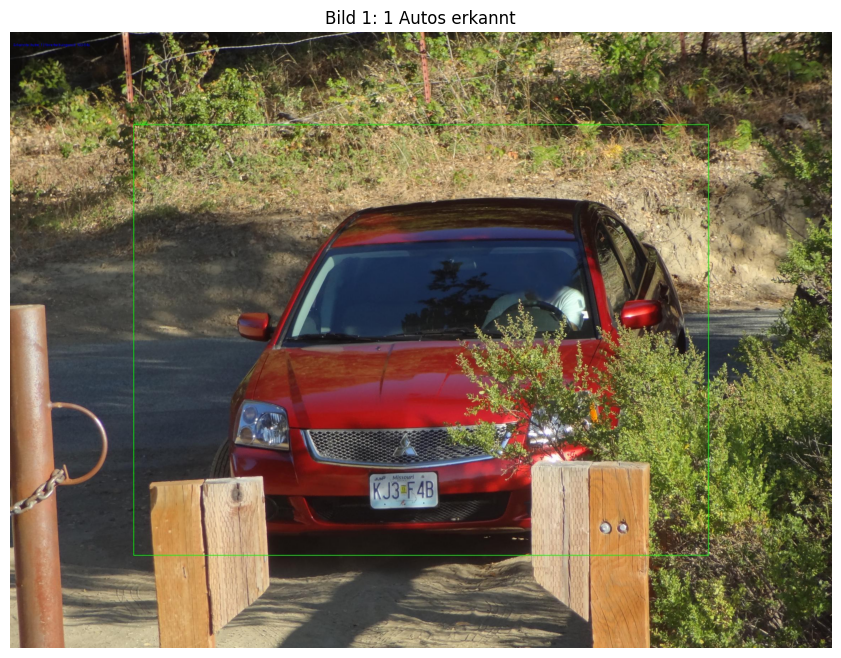

Bild 2: 12 Autos erkannt


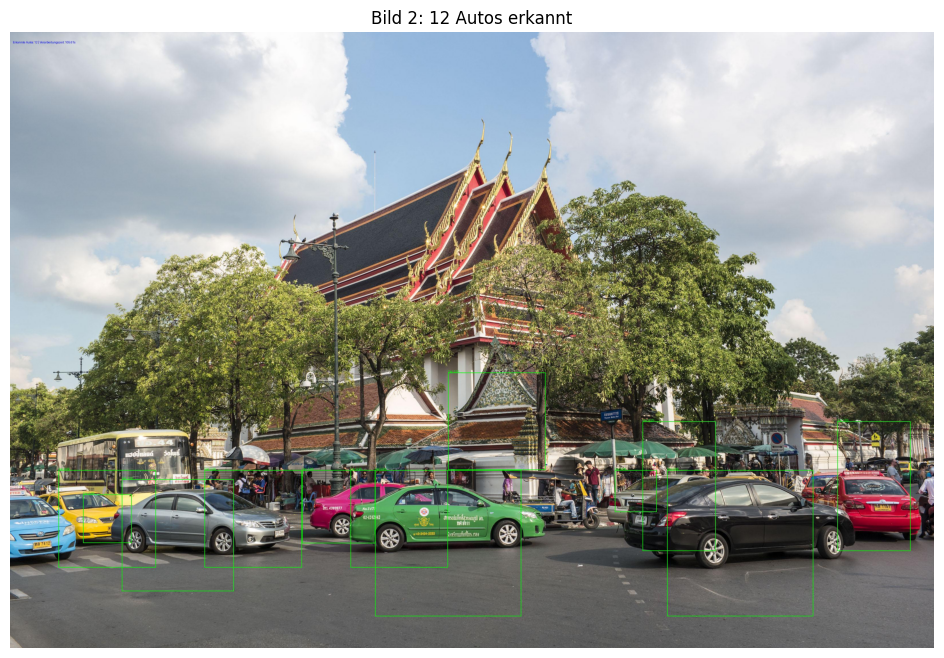

Bild 3: 21 Autos erkannt


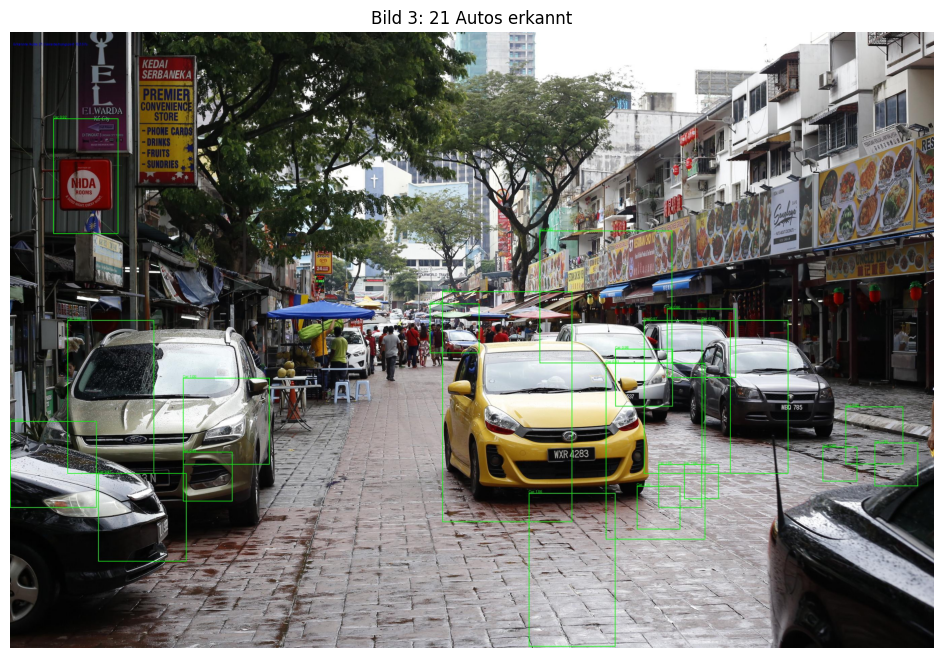

In [26]:
print("Testen der verbesserten Automerkennung auf den Bildern aus dem Repository...")

# Bilder aus dem Repository
repo_images = [
    os.path.join(images_dir, 'bild1.jpg'),
    os.path.join(images_dir, 'bild2.jpg'),
    os.path.join(images_dir, 'bild3.jpg')
]

for i, image_path in enumerate(repo_images):
    # Erkennen von Autos im Bild
    output_path = os.path.join(results_dir, f'bild{i+1}_result_improved.jpg')
    boxes = detect_and_draw_cars_improved(image_path, model, output_path)
    
    print(f"Bild {i+1}: {len(boxes)} Autos erkannt")
    
    # Anzeigen des Ergebnisses im Notebook
    plt.figure(figsize=(12, 8))
    plt.imshow(plt.imread(output_path))
    plt.title(f"Bild {i+1}: {len(boxes)} Autos erkannt")
    plt.axis('off')
    plt.show()

### Testen der verbesserten Automerkennung auf zusätzlichen Bildern aus dem Internet

Testen der verbesserten Automerkennung auf zusätzlichen Bildern aus dem Internet...
Bild 4: 17 Autos erkannt


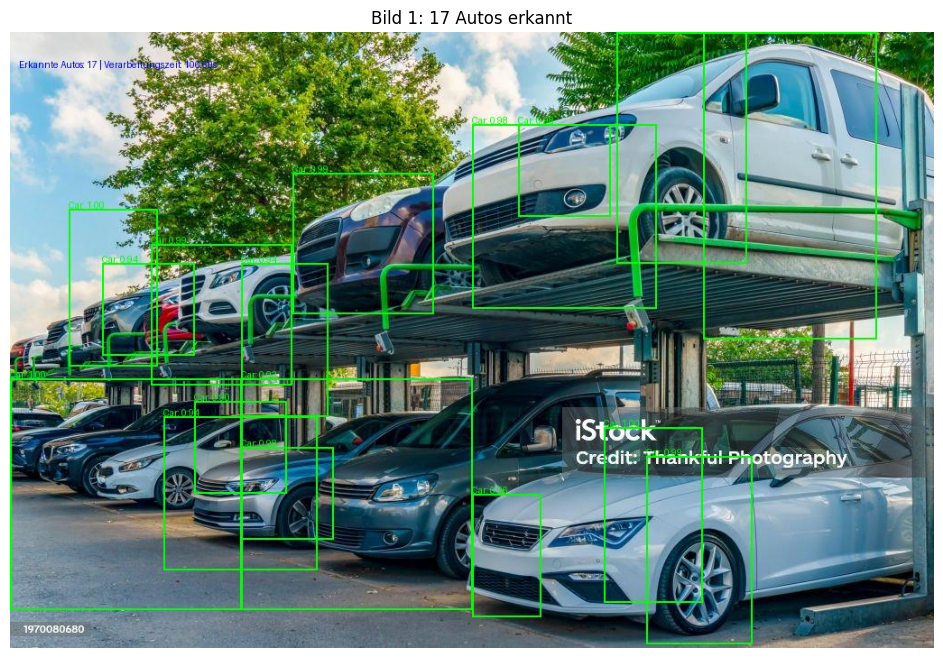

Bild 5: 5 Autos erkannt


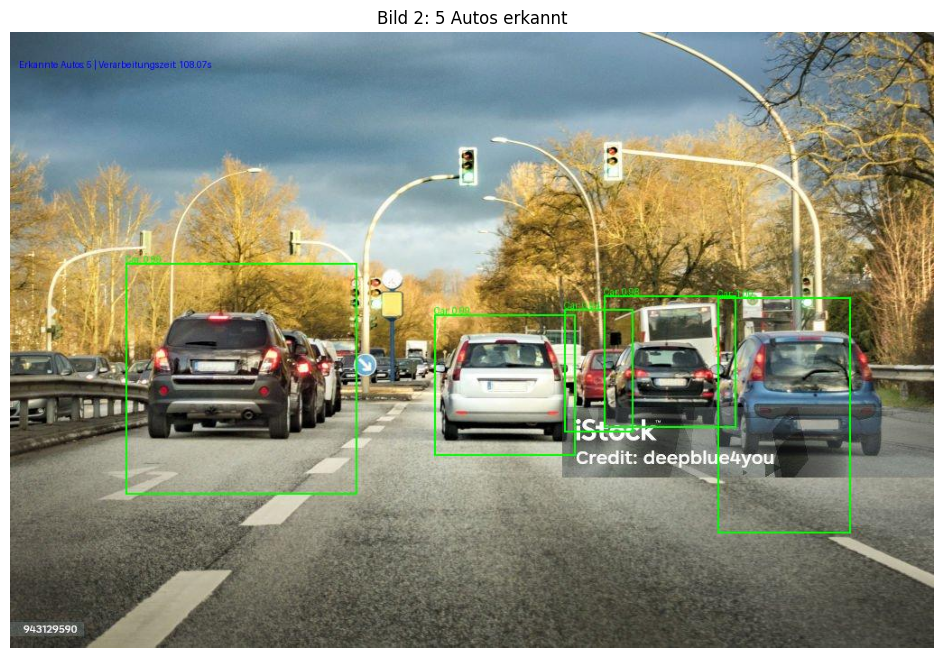

Bild 6: 36 Autos erkannt


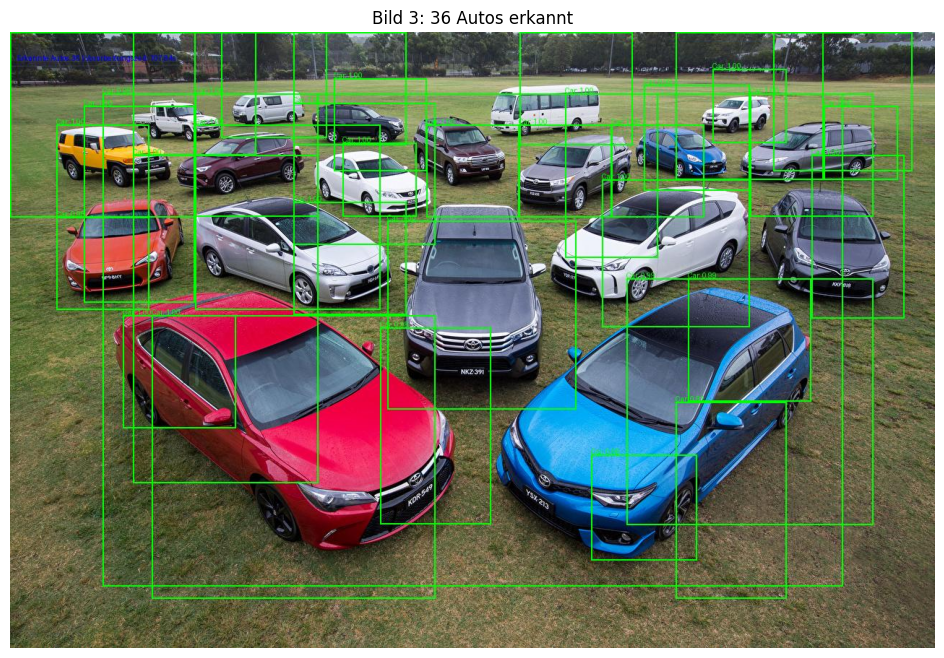

In [29]:
print("Testen der verbesserten Automerkennung auf zusätzlichen Bildern aus dem Internet...")

# Bilder aus dem Repository
additional_images = [
    os.path.join(images_dir, 'bild4.jpg'),
    os.path.join(images_dir, 'bild5.jpg'),
    os.path.join(images_dir, 'bild6.jpg')
]

for i, image_path in enumerate(additional_images):
    # Erkennen von Autos im Bild
    output_path = os.path.join(results_dir, f'bild{i+4}_result_improved.jpg')
    boxes = detect_and_draw_cars_improved(image_path, model, output_path)
    
    print(f"Bild {i+4}: {len(boxes)} Autos erkannt")
    
    # Anzeigen des Ergebnisses im Notebook
    plt.figure(figsize=(12, 8))
    plt.imshow(plt.imread(output_path))
    plt.title(f"Bild {i+1}: {len(boxes)} Autos erkannt")
    plt.axis('off')
    plt.show()

## Zusammenfassung

In diesem Notebook haben wir:
1. Ein trainiertes CNN-Modell zur Autoerkennung geladen
2. Einen verbesserten Ansatz zur Automerkennung implementiert, der eine alternative zu Selective Search für Region Proposals verwendet
3. Eine verbesserte Multi-Scale-Erkennung implementiert, um Autos unterschiedlicher Größen zuverlässiger zu erkennen
4. Eine spezielle Erkennung für sehr große Autos implementiert, die einen signifikanten Teil des Bildes einnehmen
5. Eine erweiterte Non-Maximum Suppression implementiert, die 100% überlappende Boxen entfernt und eine intelligente Filterung für verschachtelte Boxen bietet
6. Die Erkennung auf verschiedenen Testbildern angewendet und die Ergebnisse visualisiert
7. Alle Bildverarbeitungsfunktionen mit PIL anstelle von OpenCV implementiert, um Kompatibilität mit Python 3.11 zu gewährleisten

Der implementierte verbesserte Ansatz ermöglicht eine zuverlässigere Erkennung von Autos in Bildern unterschiedlicher Größen und Perspektiven. Die Verwendung einer alternativen Methode für Region Proposals anstelle des Sliding-Window-Ansatzes führt zu einer besseren Erkennung von Autos, insbesondere in komplexen Szenen mit mehreren Autos. Die spezielle Erkennung für sehr große Autos ermöglicht es, Autos zu erkennen, die einen signifikanten Teil des Bildes einnehmen. Die erweiterte Non-Maximum Suppression verhindert 100% überlappende Boxen und bietet eine intelligente Filterung für verschachtelte Boxen, die nicht einfach kleinere Boxen innerhalb größerer Boxen entfernt, sondern die Konfidenz und das Enthaltensein berücksichtigt.

In [ ]:
print("Verbesserte Automerkennung auf Bildern abgeschlossen. Die Ergebnisse wurden im Verzeichnis 'results' gespeichert.")